<h1>ImplicitEquations</h1>

<p>This paper by <a href="http://www.dgp.toronto.edu/people/mooncake/papers/SIGGRAPH2001_Tupper.pdf">Tupper</a> details a method for graphing two-dimensional implicit equations and inequalities. This package gives an implementation of the  paper's basic algorithms to allow the <code>julia</code> user to naturally represent and easily render graphs of implicit functions and equations.</p>

<p>The basic idea is to express a equation in $x$ and $y$ variables in terms of a function of two variables as a predicate. The <code>plot</code> function <code>Plots</code> is used to plot these predicates.</p>

<p>For example, the <a href="http://www-groups.dcs.st-and.ac.uk/~history/Curves/Devils.html">Devils curve</a> is graphed over the default region as follows:</p>

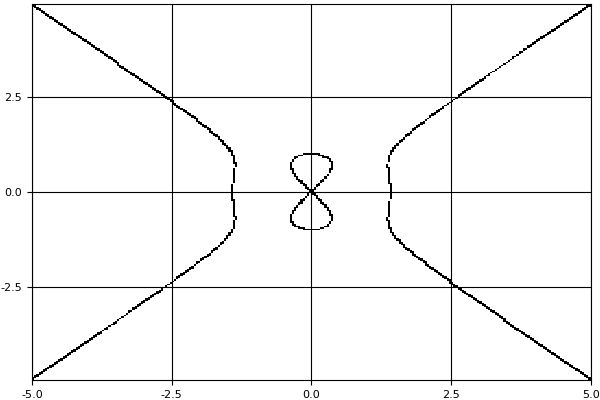

In [ ]:
using Plots, ImplicitEquations
pyplot()

a,b = -1,2
f(x,y) = y^4 - x^4 + a*y^2 + b*x^2
r = (f ⩵ 0) # \Equal[tab]
plot(r)

<p>The <code>f ⩵ 0</code> expression above creates a <code>Predicate</code> that is graphed by <code>plot</code>.  <code>Predicate</code>s are generated using the function <code>Lt</code>, <code>Le</code>, <code>Eq</code>, <code>Neq</code>, <code>Ge</code>, and <code>Gt</code>. The infix unicode operators <code>≪</code> (<code>\ll&#91;tab&#93;</code>), <code>≦</code> (<code>\leqq&#91;tab&#93;</code>), <code>⩵</code> (<code>\Equal&#91;tab&#93;</code>), <code>≶</code> (<code>\lessgtr&#91;tab&#93;</code>) or <code>≷</code> (<code>\gtrless&#91;tab&#93;</code>), <code>≧</code> (<code>\geqq&#91;tab&#93;</code>), <code>≫</code> (<code>\leqq&#91;tab&#93;</code>) may also be used.</p>

<p>For example, the <a href="http://www-history.mcs.st-and.ac.uk/Curves/Trident.html">Trident of Newton</a> can be represented in Cartesian form as follows:</p>

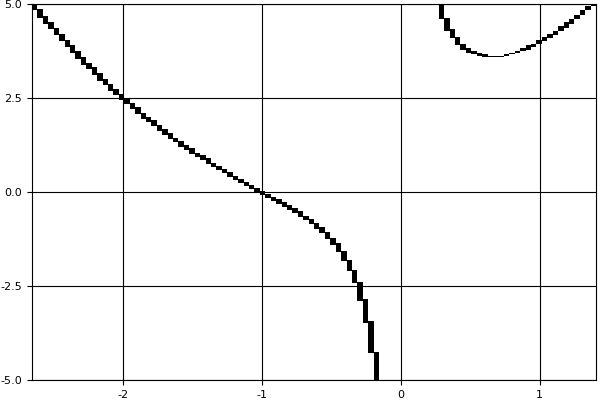

In [ ]:
## trident of Newton
c,d,e,h = 1,1,1,1
f(x,y) = x*y
g(x,y) = c*x^3 + d*x^2 + e*x + h
plot(Eq(f,g)) ## aka f ⩵ g (using Unicode\Equal<tab>)

<p>Inequalities can be graphed as well</p>

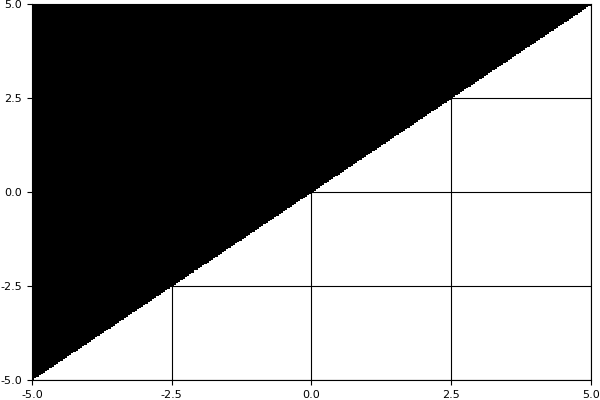

In [ ]:
f(x,y) = x - y
plot(f ≪ 0) # \ll[tab]

<p>This example is from Tupper's paper:</p>

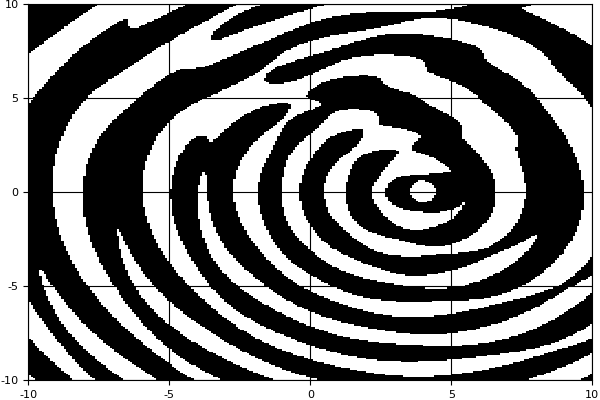

In [ ]:
f(x,y) = (y-5)* cos(4sqrt((x-4)^2 +y^2))
g(x,y) = x * sin(2*sqrt(x^2 + y^2))

plot(Ge(f,  g), xlims=(-10, 10), ylims=(-10, 10))

<p>This graph illustrates the algorithm employed to graph <code>f ⩵ 0</code> where <code>f&#40;x,y&#41; &#61; y - sqrt&#40;x&#41;</code>:</p>

<p><img src="http://i.imgur.com/8Mtmb7v.png" alt="Algorithm" /></p>

<p>The basic algorithm is to initially break up the graphing region into square regions. (This uses the number of pixels, which are specified by <code>W</code> and <code>H</code> above.)</p>

<p>These regions are checked for the predicate.</p>

<ul>
<li><p>If definitely not, the region is labeled "white;"</p>
</li>
<li><p>if definitely yes, the region is labeled "black;"</p>
</li>
<li><p>else the square region is subdivided into 4 smaller regions and the</p>
</li>
</ul>

<p>above is repeated until subdivision would be below the pixel level. At which point, the remaining "1-by-1" pixels are checked for possible solutions, for example for equalities where continuity is known a random sample of points is investigated with the intermediate value theorem. A region may be labeled "black" or "red" if the predicate is still ambiguous.</p>

<p>The graph plots each "black" region as a "pixel". The "red" regions may optionally be colored, if a named color is passed through the keyword <code>red</code>.</p>

<p>For example, the Devil's curve is a bit different with red coloring:</p>

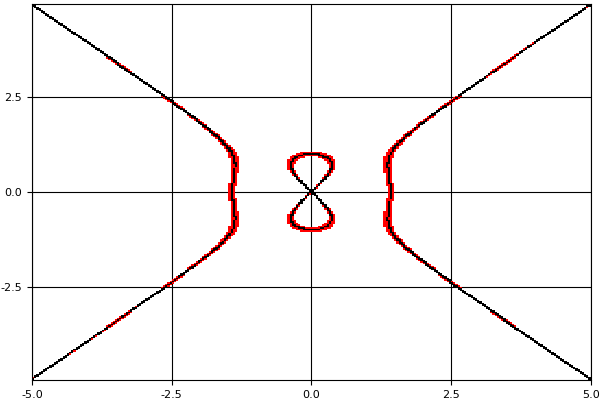

In [ ]:
a,b = -1,2
f(x,y) = y^4 - x^4 + a*y^2 + b*x^2
r = (f ⩵ 0)
plot(r, red=:red)   # show undecided regions in red

<p>The <code>plot</code> function accepts the usual keywords of <code>Plots</code> and also:</p>

<ul>
<li><p>the number of pixels is a power of 2 and specified by <code>plot&#40;pred, N&#61;4, M&#61;5&#41;</code>. The default is <code>M&#61;8</code> by <code>N&#61;8</code> or 256 x 256.</p>
</li>
<li><p>the colors red and black can be adjusted with the keywords <code>red</code> and <code>black</code>.</p>
</li>
</ul>

<p>This example, the <a href="http://yangkidudel.wordpress.com/2011/08/02/love-and-mathematics/">Batman equation</a>, Uses a few new things: the <code>screen</code> function is used to restrict ranges and logical operators to combine predicates.</p>

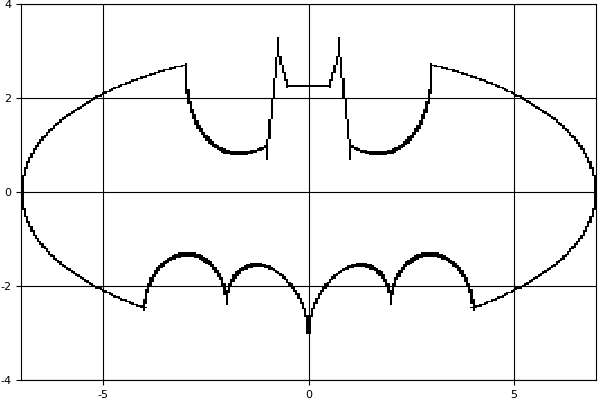

In [ ]:
f0(x,y) = ((x/7)^2 + (y/3)^2 - 1)  *   screen(abs(x)>3) * screen(y > -3*sqrt(33)/7) 
f1(x,y) = ( abs(x/2)-(3 * sqrt(33)-7) * x^2/112 -3 +sqrt(1-(abs((abs(x)-2))-1)^2)-y)
f2(x,y) = y - (9 - 8*abs(x))       *   screen((abs(x)>= 3/4) &  (abs(x) <= 1) )
f3(x,y) = y - (3*abs(x) + 3/4)     *   I_((1/2 < abs(x)) & (abs(x) < 3/4))    # alternate name for screen
f4(x,y) = y - 2.25                 *   I_(abs(x) <= 1/2) 
f5(x,y) = (6 * sqrt(10)/7 + (1.5-.5 * abs(x)) - 6 * sqrt(10)/14 * sqrt(4-(abs(x)-1)^2) -y) * screen(abs(x) >= 1)

r = (f0 ⩵ 0) | (f1 ⩵ 0) | (f2 ⩵ 0) | (f3 ⩵ 0) | (f4 ⩵ 0) | (f5 ⩵ 0)
plot(r, xlims=(-7, 7), ylims=(-4, 4), red=:black)

<p>The above example illustrates a few things:</p>

<ul>
<li><p>predicates can be joined logically with <code>&amp;</code>, <code>|</code>. Use <code>&#33;</code> for negation.</p>
</li>
<li><p>The <code>screen</code> function can be used to restrict values according to some predicate call.</p>
</li>
<li><p>the logical comparisons such as <code>&#40;abs&#40;x&#41; &gt;&#61; 3/4&#41; &amp; &#40;abs&#40;x&#41; &lt;&#61; 1&#41;</code> within <code>screen</code> are not typical in that one can't write <code>3/4 &lt;&#61; abs&#40;x&#41; &lt;&#61; 1</code>, a convenient <code>Julian</code> syntax. This is due to the fact that the "<code>x</code>s" being evaluated are not numbers, rather intervals via <code>ValidatedNumerics</code>. For intervals, values may be true, false or "maybe" so a different interpretation of the logical operators is given that doesn't lend itself to the more convenient notation.</p>
</li>
<li><p>rendering can be slow. There are two reasons: images that require a lot of checking, such as the inequality above, are slow just because more regions must be analyzed. As well, some operations are slow, such as division, as adjustments for discontinuities are slow. (And by slow, it can mean really slow. The difference between rendering <code>&#40;1-x^2&#41;*&#40;2-y^2&#41;</code> and <code>csc&#40;1-x^2&#41;*cot&#40;2-y^2&#41;</code> can be 10 times.)</p>
</li>
</ul>

<h2>A "typical" application</h2>

<p>A common calculus problem is to find the tangent line using implicit differentiation. We can plot the predicate to create the implicit graph, then add a layer with <code>plot&#33;</code>:</p>

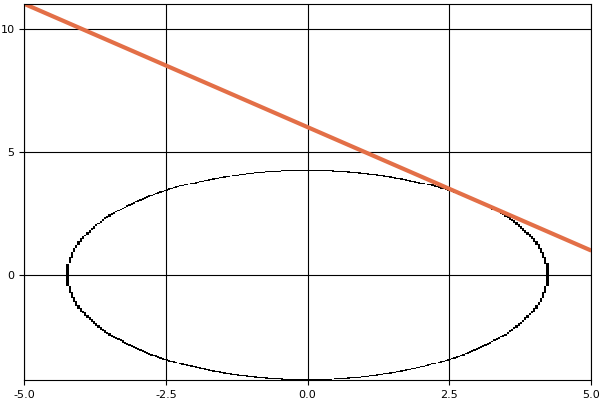

In [ ]:
f(x,y) = x^2 + y^2
plot(f ⩵ 2*3^2)

## now add tangent at (3,3)
a,b = 3,3
dydx(a,b) = -b/a             # implicit differentiate to get dy/dx =-y/x
tl(x) = b + dydx(a,b)*(x-a)  
plot!(tl, linewidth=3, -5, 5)

<h2>Alternatives</h2>

<p>Many such plots are simply a single level of a contour plot. Contour plots can be drawn with the <code>Plots</code> package too. A simple contour plot will be faster than this package.</p>

<p>The <code>SymPy</code> package exposes SymPy's <code>plot_implicit</code> feature that will implicitly plot a symbolic expression in 2 variables including inequalities. The algorithm there also follows Tupper and uses interval arithmetic, as possible.</p>

<p>The package <a href="https://github.com/dpsanders/IntervalConstraintProgramming.jl">IntervalConstraintProgramming </a> also allows for this type of graphing, and momre.</p>

<h2>TODO</h2>

<p><em>LOTS</em>:</p>

<ul>
<li><p>Check out these graphs to see which can be done</p>
</li>
<li><p>http://www.xamuel.com/graphs-of-implicit-equations/</p>
</li>
<li><p>http://www.peda.com/grafeq/gallery.html</p>
</li>
<li><p>branch cut tracking and interval sets are employed by Tupper, these could be added. This would allow some other functions such as <code>mod</code>, or <code>±</code> to be defined.</p>
</li>
<li><p>Tupper sketches out how to be more rigorous with computing whether a region is black or white.</p>
</li>
<li><p>increase speed (could color 1-pixel regions better if so, perhaps; division checks; type stability).</p>
</li>
</ul>